In [1]:
from time import time
import shutil
import random
import os

import pandas as pd
import cv2
import matplotlib.pyplot as plt
from functools import lru_cache
import numpy as np
from scipy import ndimage, stats
from itertools import islice

# define optical flow based feature extractions 

In [2]:
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def mutating_base_calcs(df, n):
    df['dx'] = df.x2 - df.x1 + 0.00001
    df['dy'] = (df.y2 - df.y1)/n
    df['Vf_slope'] = df.dy/df.dx
    df['|Vf|'] = np.sqrt(df.dx**2 + df.dy**2)

    df['right_direction'] = (df.y2>df.y1) & (abs(df.Vf_slope) > 3) # down and steep
    df['good'] = df['right_direction']

def analyze_lk_optical_flow_dfs(dfs):
    xs = []
    def analyze_df(df):
        nonlocal xs
        # absurd
        #df['good'] = df['good'] & (df['|Vf|'] > 2.5)
        df['good'] = df['good'] & (df['|Vf|'] < (45/.577)) #25 is data set max, .577 coverts from Vf to velocity
        
        if sum(df['good']==True) == 0:
            xs += [np.nan, np.nan]
        else:
            with np.errstate(divide='ignore',invalid='ignore'):
                df.loc[df['good'],'z'] = stats.zscore(df.loc[df['good'],'|Vf|'])
            df.loc[df['good']==False,'z'] = 100.0
            df['good'] = df['good'] & (df['z'] < 1.7)

            if len(df) != 0:
                # filter out noisy "small" flow vectors
                Vf_max_good = df[df['good']==True]['|Vf|'].max()
                df['good'] = df['good'] & (df['|Vf|'] > Vf_max_good * 0.25)
            xs.append(df.loc[df['good'],'|Vf|'].mean())
            xs.append(df.loc[df['good'],'|Vf|'].std())
        xs.append(df['dy'].mean())
    overall = 0
    for n, df in enumerate(dfs):
        global N
        N = n + 1
        mutating_base_calcs(df,N)
        analyze_df(df)
        
        overall += df.loc[df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    stacked_df = pd.concat(dfs, ignore_index=True)
    analyze_df(stacked_df)
    overall += stacked_df.loc[stacked_df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    xs.append(overall)

    # 0 1 2 #n=1
    # 3 4 5 #n=2
    # 6 7 8 #n=3
    # 9 10 11 #stacked
    # 12 #overall
    return xs

def via_lk_optical_flow_multi(frame, count=3):
    frame['optical_flow'] = []
    dfs = []
    for i in range(1, count+1):
        dfs.append(optical_flow(frame['_'], frame[str(i)], frame))
    return analyze_lk_optical_flow_dfs(dfs)

def debug_optical(df,img):
    img = image_next.copy()
    # we lose old arrow debugging with the df approach, sorry
    #         if right_direction:
    #             color=255
    #             df.loc[i,'good'] = True
    #         else:
    #             color=130
    #             df.loc[i,'good'] = False

    #         if debugging:
    #             img = cv2.arrowedLine(img,(int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
    #             img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    if len(df) == 0:
        print("no useful points")
    else:
        display(df.sort_values(by='|Vf|'))       
        bins = list(range(0,101,10))
        plt.rcParams['figure.figsize'] = [20, 5]
        df['|Vf|'].hist(bins=bins)
        df[df['good']==True]['|Vf|'].hist(bins=bins)
        plt.show()

    plt.rcParams['figure.figsize'] = [20, 12]
    plt.imshow(img)
    plt.show()

# params for ShiTomasi corner detection
feature_params = dict(
    maxCorners = 140,
    qualityLevel = 0.004,
    minDistance = 20,
    blockSize = 9,
    #useHarrisDetector = True,
    )

# Parameters for lucas kanade optical flow
lk_params = dict(
    winSize  = (15,15),
    maxLevel = 1,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

def optical_flow(image, image_next, frame, debugging=False):
    p0 = cv2.goodFeaturesToTrack(image, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(image, image_next, p0, None, **lk_params)
    
    points = []
    for new, old in zip(p1[st==1],p0[st==1]):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        points.append((x1,x2,y1,y2))
    
    df = pd.DataFrame(data=points, columns=('x1','x2','y1','y2'))
    if debugging:
        debug_optical(df,img)

    frame['optical_flow'].append(df)
    return df


# define extraction pipline

In [3]:
def lookahead(frames, count=3):
    # add "lookahead" in keys '1', '2', ...
    # repeats at the end to keep length len
    fs = list()
    def _updated_f():
        f = fs.pop(0)
        f.update({str(n+1):f['_'] for n, f in enumerate(fs)})
        return f 
        
    for f in frames:
        fs.append(f)
        if len(fs) > count:
            yield _updated_f()

    for _ in range(count):
        fs.append(f)
        yield _updated_f()
        
def print_frame_keys(frames):
    for f in frames:
        print(repr(list(f.keys())))
        yield f

def view_frames(frames):
    for f in frames:
        for k in f.keys():
            try:
                cv2.imshow(k,f[k])
            except:
                pass
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f
    cv2.destroyAllWindows()

def persist_raw_optical_flow(frames):
    import os
    path = f'./data/{int(time())}'
    os.makedirs(path)
    for i, f in enumerate(frames):
        for j, df in enumerate(f['optical_flow']):
            df: pd.DataFrame
            df.to_pickle(os.path.join(path,f'{i}_{j}.pkl'))
        yield f

class FeatureExtractor():
    def __init__(self):
        self._steps = []

    def add_step(self, step):
        """step(frames_iterator) yields-> [frame,frame,...]; you can filter or gather frames"""
        if callable(step):
            self._steps.append(step)

    def add_processor(self, processor):
        """processor(img) returns-> img; frame['_'] is mutated"""
        def _step(frames):
            for f in frames:
                f['_'] = processor(f['_'])
                yield f
        self.add_step(_step)

    def add_analyzer(self, analyzer):
        """analyzer(frame) returns-> [x1,x2,...]; frame['_'] is forwarded untouched, features are collected"""
        def _step(frames):
            for f in frames:
                f['xs'] += analyzer(f)
                yield f
        self.add_step(_step)
        
    def extract_features(self, file='../data/train.mp4'):
        frames = self._frames(file)
        pipeline = self._make_pipe(frames)
        self._start = time()
        self._last = self._start
        X = []
        i = 0
        for i, f in enumerate(pipeline):
            X.append(f['xs'])
            self._pprogress(i)
        self._pprogress(i,True)
        return X

    def _frames(self, file):
        vidcap = cv2.VideoCapture(file)
        while True:
            success, image = vidcap.read()
            if success:
                yield {'orig': image, '_': image, 'xs':[]}
            else:
                return

    def _make_pipe(self, frames):
        pipeline = frames
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline

    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self._start)/60:2.1f} minutes")


# run extraction pipeline
easy to hand tune and add/remove stages here

some stages are for interactive debugging, or persisting intermediates to disk

In [4]:
fe = FeatureExtractor()

# limit frames (start, stop, step)
#fe.add_step(lambda g: islice(g, 17500, 20400, 1)) 
#fe.add_step(lambda g: islice(g, 400, 420, 1))

fe.add_processor(lambda img: crop(img, bottom=100, top=220))
fe.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
fe.add_processor(fix_perspective)
fe.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

fe.add_step(lambda frames: lookahead(frames, count=3))

fe.add_analyzer(via_lk_optical_flow_multi)

fe.add_step(persist_raw_optical_flow)
#fe.add_step(print_frame_keys)
#fe.add_step(view_frames)

xs = fe.extract_features('../data/train.mp4')

492 processed in 0.5 minutes
988 processed in 1.0 minutes
1616 processed in 1.5 minutes
2281 processed in 2.0 minutes
2947 processed in 2.5 minutes
3585 processed in 3.0 minutes
4271 processed in 3.5 minutes
4971 processed in 4.0 minutes
5605 processed in 4.5 minutes
6285 processed in 5.0 minutes
6964 processed in 5.5 minutes
7631 processed in 6.0 minutes
8294 processed in 6.5 minutes
8979 processed in 7.0 minutes
9658 processed in 7.5 minutes
10326 processed in 8.0 minutes
10978 processed in 8.5 minutes
11639 processed in 9.0 minutes
12291 processed in 9.5 minutes
12960 processed in 10.0 minutes
13622 processed in 10.5 minutes
14278 processed in 11.0 minutes
14958 processed in 11.5 minutes
15615 processed in 12.0 minutes
16301 processed in 12.5 minutes
16962 processed in 13.0 minutes
17468 processed in 13.5 minutes
17975 processed in 14.0 minutes
18476 processed in 14.5 minutes
18978 processed in 15.0 minutes
19487 processed in 15.5 minutes
19991 processed in 16.0 minutes
20400 proces

# Join with training ground truth

In [5]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
#X.describe()

In [6]:
def fill_nan(df):
    df.fillna(df.rolling(10,min_periods=1,win_type='nuttall').mean(), inplace=True)
    df.fillna(method='pad', inplace=True)
fill_nan(X)
#X.describe()

In [7]:
Xy = X.copy()
Xy['y'] = y.copy()

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [8]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.001]]) # smaller is more resistance to acceleration
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
#kf = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [9]:
# mean(|Vf|) stdev(|Vf|) mean(dy)
# 0  1  2   #n=1
# 3  4  5   #n=2
# 6  7  8   #n=3
# 9  10 11  #stacked
# 12        #overall

y_pred_col = 12
velocity_per_vf = .577

def filter_scaled_cloud_for_stop(series):
    def a(span):
        height_thresh = 2.6
        fraction_under_thresh_required = 1/6.8
        return sum((span < height_thresh)) > (len(span)*fraction_under_thresh_required)
    def b(span):
        height_thresh = 2.6
        fraction_under_thresh_required = 1/6.8
        return np.std(span) > 7.5
    almost_stopped_mask = series.rolling(165,center=True, min_periods=1).apply(a)
    stopped_mask = series.rolling(165,center=True, min_periods=1).apply(b) * almost_stopped_mask
    going  = series * (almost_stopped_mask==False)
    
    return ((.5+np.log(series))*almost_stopped_mask + going)/(stopped_mask*5+1)

def kf_and_scale(df):
    df['y_pred_scaled'] = df[y_pred_col] * velocity_per_vf
    df['y_pred_scaled_stop'] = filter_scaled_cloud_for_stop(df['y_pred_scaled'])
    df.loc[df['y_pred_scaled_stop'] < 0, 'y_pred_scaled_stop'] = 0
    df['y_pred_kf'] = kf.smooth(df['y_pred_scaled_stop'].values)[0]

kf_and_scale(Xy)

In [10]:
Xy.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,y_pred_scaled,y_pred_scaled_stop,y_pred_kf
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,21.427657,5.383220,4.231731,21.192014,5.463193,2.506489,20.957311,5.561325,2.019250,20.934509,5.376617,2.946066,21.113576,12.183182,12.182533,11.877950,11.876760
std,15.212521,3.835936,9.338386,15.009446,4.087978,7.346373,14.624974,4.300986,6.591809,14.710831,3.749512,6.797021,14.579132,8.206763,8.412159,8.714544,8.144501
min,0.005787,0.002447,-93.586485,0.001757,0.000472,-102.203007,0.002043,0.001012,-85.986661,0.009909,0.004602,-91.635145,0.052917,0.000000,0.030533,0.000000,0.064550
25%,8.174027,2.426449,-0.440348,8.128919,2.210599,-0.994233,8.280322,2.124302,-1.134300,8.155312,2.315618,-0.535750,8.448800,5.011801,4.874957,4.150292,4.829169
50%,17.767399,4.539275,3.500123,17.588402,4.399375,2.059200,17.626830,4.411172,1.628464,17.331171,4.569808,2.450806,17.787052,10.600500,10.263129,10.167578,10.616247
75%,34.698355,7.547442,9.063136,34.383211,8.113885,6.002078,33.981543,8.349534,5.017001,34.293573,8.085174,6.314529,34.329734,21.324059,19.808257,19.807319,20.341707
max,61.287489,29.710683,83.617086,63.577766,32.148217,52.399969,63.803562,32.010217,47.029412,59.948067,26.337664,49.815615,58.834196,28.130404,33.947331,33.947331,26.401155


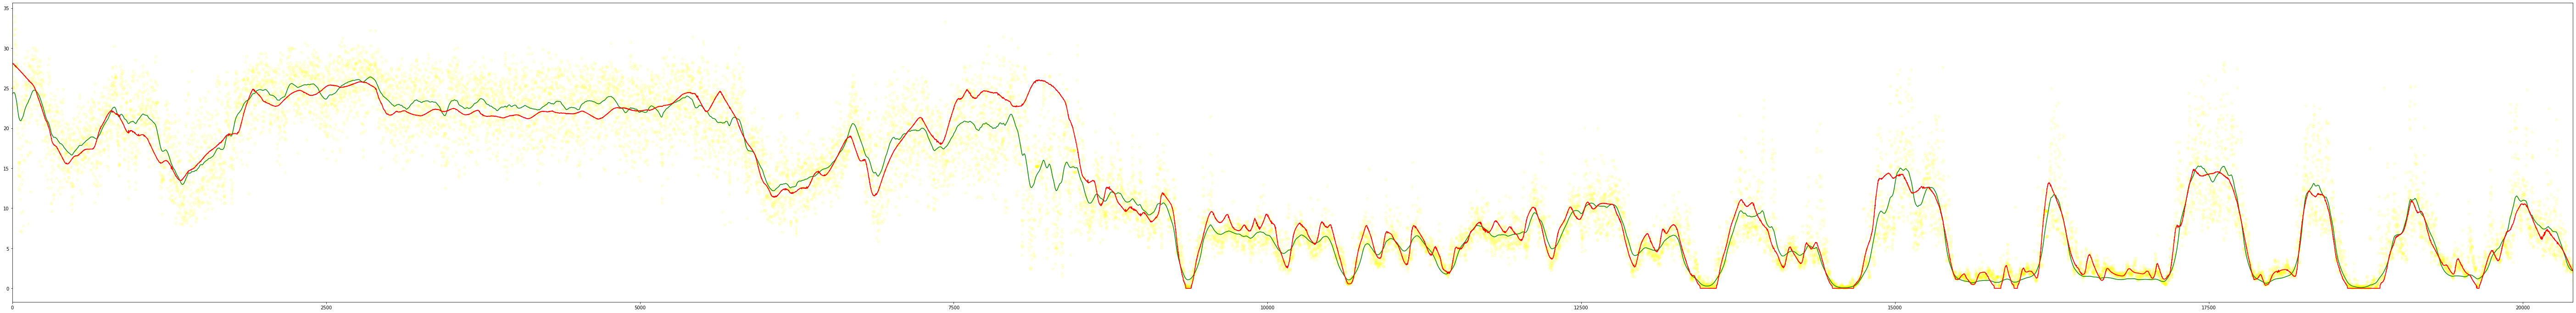

In [11]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy)))

def plot(df, ix_mask, column, **kwargs):
    try:
        if ix_mask is None:
            df = df.loc[:,column]
        else:
            df = df.loc[ix_mask, column]
        plt.plot(df.index, df.values, **kwargs)
    except KeyError:
        print(f"Skipping {column}")
    
plot(Xy, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(Xy, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
plot(Xy, None, 'y', marker='', linewidth=1.7, color='red')

# Train Set Error

In [12]:
err = ((Xy['y'] - Xy['y_pred_kf'])**2).mean()
print(f"MSE\n{err:0.1f}", end='\t') # 10.3 was best, gaussian made it 7.2, 3.4 with tweaks to Flow Vector filtering

MSE
3.8	

# Run same pipeline on test.mp4

In [13]:
xs_test = fe.extract_features(file='../data/test.mp4')

553 processed in 0.5 minutes
1113 processed in 1.0 minutes
1693 processed in 1.5 minutes
2242 processed in 2.0 minutes
2803 processed in 2.5 minutes
3363 processed in 3.0 minutes
3930 processed in 3.5 minutes
4489 processed in 4.0 minutes
5044 processed in 4.5 minutes
5593 processed in 5.0 minutes
6139 processed in 5.5 minutes
6684 processed in 6.0 minutes
7232 processed in 6.5 minutes
7773 processed in 7.0 minutes
8329 processed in 7.5 minutes
8877 processed in 8.0 minutes
9434 processed in 8.5 minutes
10000 processed in 9.0 minutes
10541 processed in 9.5 minutes
10798 processed in 9.7 minutes


In [14]:
X_test = pd.DataFrame(xs_test)
fill_nan(X_test)
kf_and_scale(X_test)

# Sanity check final result

Training, Red=ground truth, Green is prediction


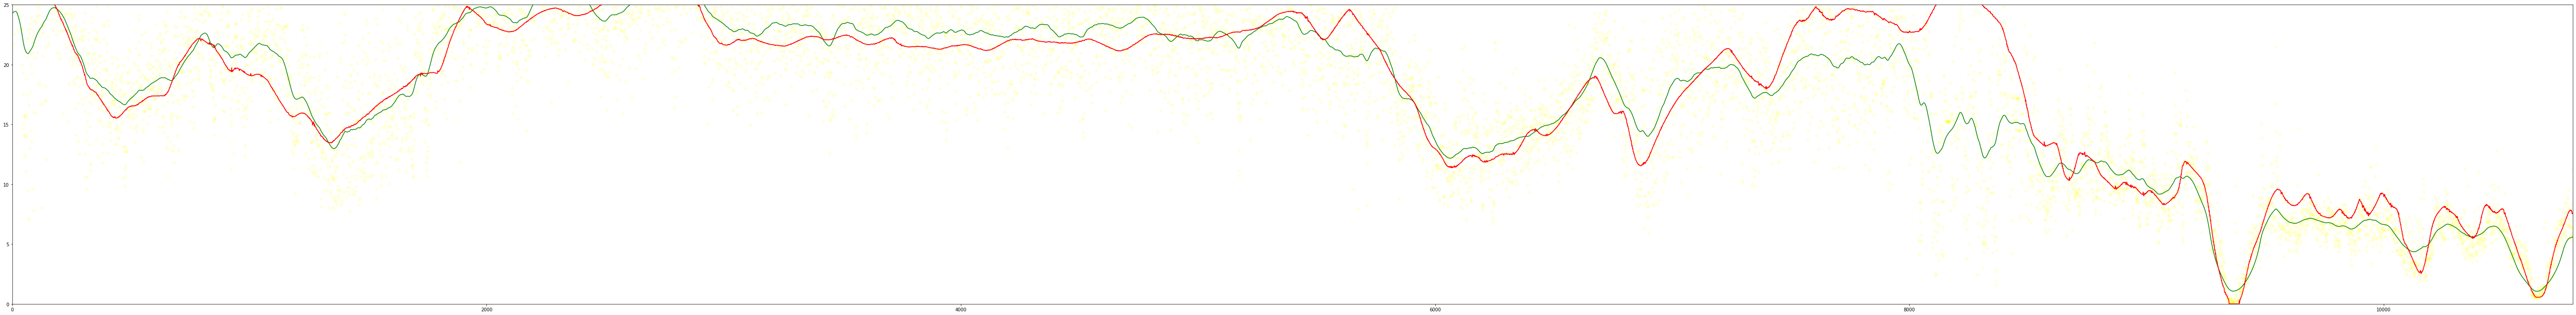

Test


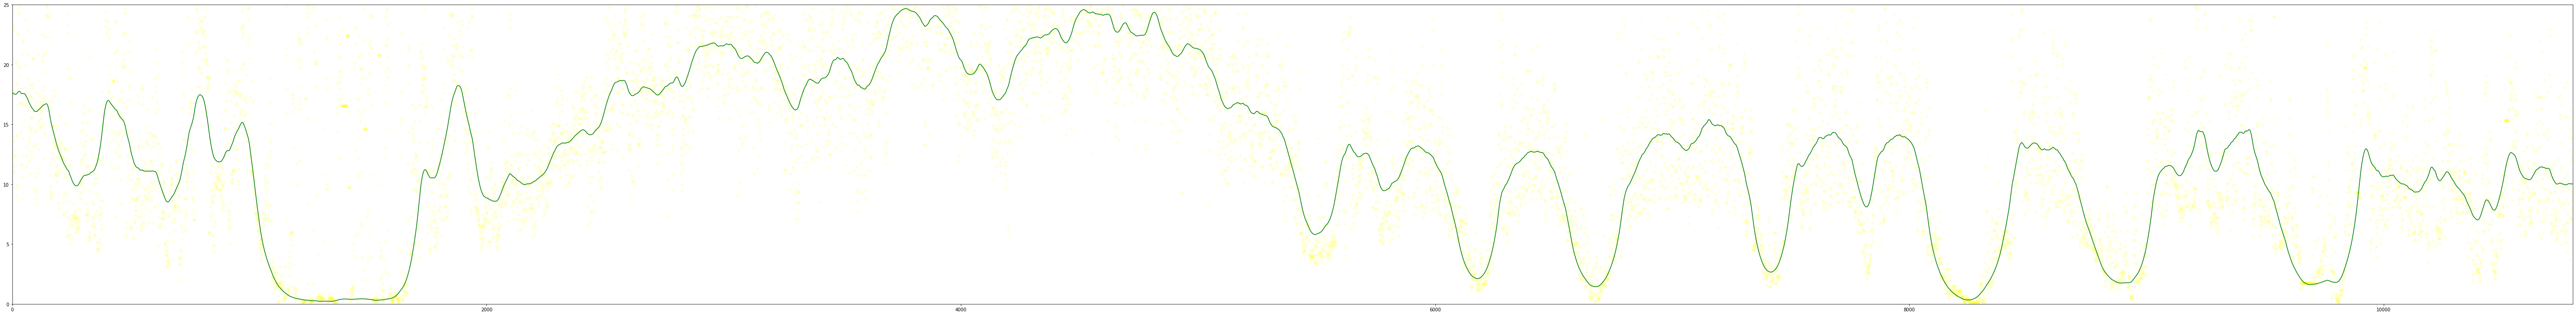

In [25]:
plt.gca().set_xlim((0,len(X_test)))
plt.gca().set_ylim((0,25))
print("Training, Red=ground truth, Green is prediction")
plot(Xy, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(Xy, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
plot(Xy, None, 'y', marker='', linewidth=1.7, color='red')
#plot(Xy, None, 'blue', marker='', linewidth=1.5, color='blue')
plt.show()
plt.gca().set_xlim((0,len(X_test)))
plt.gca().set_ylim((0,25))
print("Test")
plot(X_test, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(X_test, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
#plot(X_test, None, 'blue', marker='', linewidth=1.5, color='blue')

In [16]:
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y_pred_scaled,y_pred_scaled_stop,y_pred_kf
count,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000
mean,22.899525,6.377581,9.185785,22.846986,6.571117,5.642368,22.449572,6.600608,4.054340,22.409116,6.326248,6.411848,22.591526,13.035310,12.208040,12.206410
std,13.689974,4.255898,12.693319,13.548610,4.689759,9.195781,13.343074,4.828161,7.654972,13.097473,4.208973,8.993878,12.643687,7.295407,7.822454,6.490759
min,0.001651,0.000344,-366.180580,0.001158,0.000145,-175.058533,0.001227,0.000083,-112.619484,0.002794,0.001117,-217.952866,0.007757,0.004476,0.000000,0.212476
25%,12.065159,3.211175,1.458874,12.343518,2.999417,0.313103,12.459546,2.902908,-0.029244,12.169465,3.054317,1.016873,12.894630,7.440202,6.291874,8.658151
50%,21.332233,5.337084,8.475071,21.075558,5.260968,5.119495,20.660378,5.312160,3.478273,20.838453,5.213845,5.793122,21.433925,12.367375,11.651231,12.244909
75%,33.389151,9.208780,16.143060,33.177525,9.803764,10.184962,31.986196,9.717963,7.549307,32.533801,9.500748,10.995430,32.249196,18.607786,18.268391,16.972961
max,63.240360,28.349982,131.333580,63.567674,30.785619,76.896170,63.584315,31.736561,70.023131,61.418083,27.896786,74.981662,57.064525,32.926231,32.926231,24.683889


# write out

In [17]:
def write_result(series):
    path = f'{int(time())}_msetrain:{err:0.1f}_test.txt'
    series.apply(lambda f: f"{f:0.6f}").to_csv(path, index=False, header=False)
    with open(path, 'ab') as dst:
        dst.seek(-1, os.SEEK_END)
        dst.truncate()
write_result(X_test['y_pred_kf'])

In [18]:
!md5sum ll.txt 

ba3b4bbbfb86f95131ae80f4af97f4f1  ll.txt


In [19]:
!md5sum ../data/train.txt

ba3b4bbbfb86f95131ae80f4af97f4f1  ../data/train.txt


In [20]:
!ls *test.txt

1604022268_msetrain:3.4_test.txt  1604027539_msetrain:3.4_test.txt  test.txt
1604026403_msetrain:3.8_test.txt  1604029274_msetrain:3.5_test.txt
1604027426_msetrain:3.4_test.txt  1604032201_msetrain:3.8_test.txt
